In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
#load the dataset
data = pd.read_csv("LoanApprovalPrediction.csv")

In [62]:
# Display the first 5 rows of the dataframe
data.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [63]:
# Count and print the number of categorical variables in the dataframe

obj = (data.dtypes == 'object')
print("Categorical variables:",len(list(obj[obj].index)))

Categorical variables: 7


In [64]:
# Dropping Loan_ID column
data.drop(['Loan_ID'],axis=1,inplace=True)

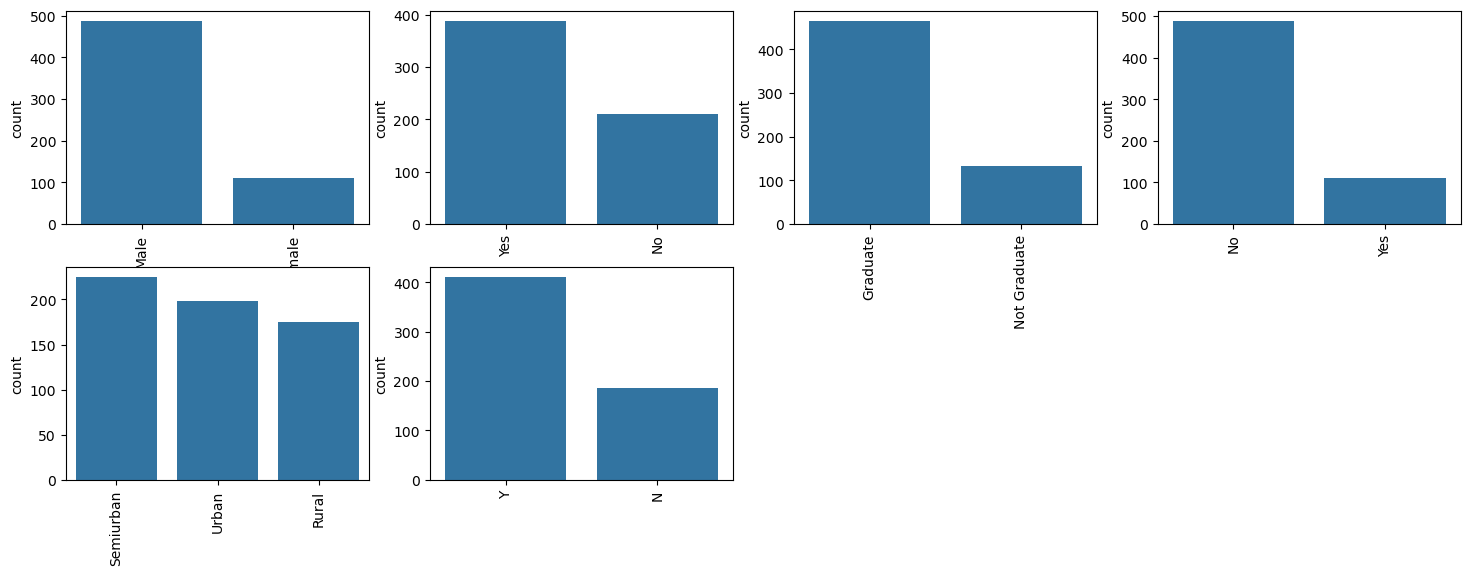

In [66]:
# Visualize value counts for all categorical columns to see dominant values

obj = (data.dtypes == 'object')          # Get categorical columns
object_cols = list(obj[obj].index)

plt.figure(figsize=(18, 36))             # Set figure size
index = 1

for col in object_cols:
    y = data[col].value_counts()         # Count unique values
    plt.subplot(11, 4, index)            # Create subplot
    plt.xticks(rotation=90)             # Rotate x labels
    sns.barplot(x=list(y.index), y=y)   # Bar plot for value counts
    index += 1


In [76]:
# Import label encoder
from sklearn import preprocessing
import joblib

# Create label encoder object
label_encoder = preprocessing.LabelEncoder()

# Get all categorical columns
obj = (data.dtypes == 'object')

# Encode each categorical column
for col in list(obj[obj].index):
    data[col] = label_encoder.fit_transform(data[col])

# Save the encoder for later use
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [77]:
# Check how many categorical (object) columns remain after encoding
obj = (data.dtypes == 'object')
print("Categorical variables:", len(list(obj[obj].index)))


Categorical variables: 0


<Axes: >

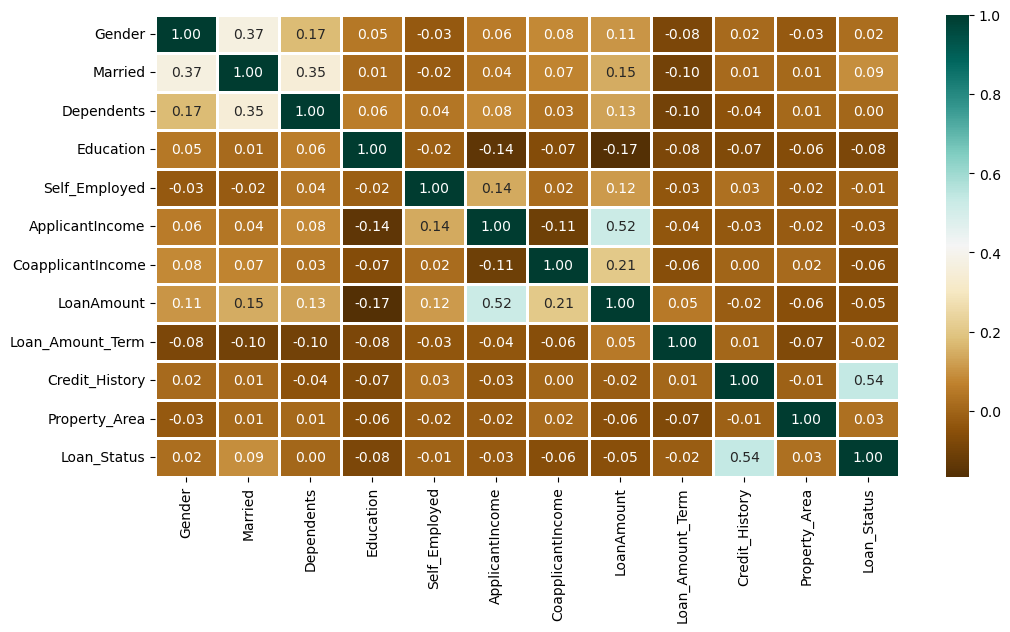

In [78]:
# Plot a heatmap to show correlation between numerical features
plt.figure(figsize=(12, 6))
sns.heatmap(data.corr(), cmap='BrBG', fmt='.2f',
            linewidths=2, annot=True)


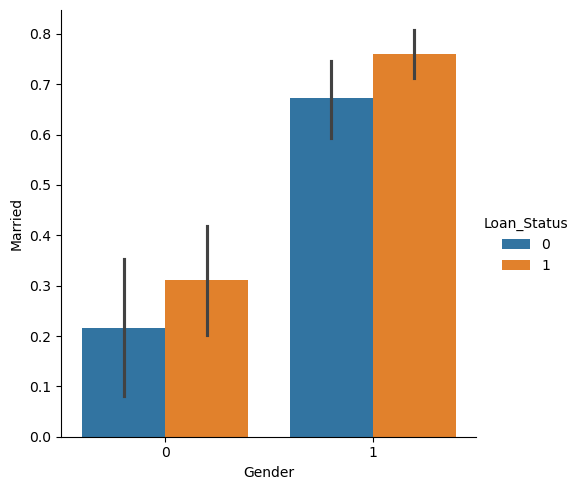

In [70]:
# Create a bar plot showing the relationship between Gender, Married, and Loan_Status
sns.catplot(x="Gender", y="Married",
            hue="Loan_Status", 
            kind="bar", 
            data=data)


In [71]:
# Fill missing values in each column with the column's mean (works only for numeric columns)
for col in data.columns:
    data[col] = data[col].fillna(data[col].mean())

# Check if any missing values remain
data.isna().sum()


Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [72]:
# Split the dataset into features (X) and target (Y)
X = data.drop(['Loan_Status'], axis=1)
Y = data['Loan_Status']

# Check the shapes of X and Y
X.shape, Y.shape

# Split the data into training and testing sets (60% train, 40% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.4,
                                                    random_state=1)

# Check the shapes of the split data
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape


((358, 11), (240, 11), (358,), (240,))

In [73]:
# Train multiple classifiers and select the best one based on training accuracy

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import pickle

# Initialize models
knn = KNeighborsClassifier(n_neighbors=3)
rfc = RandomForestClassifier(n_estimators=7, criterion='entropy', random_state=7)
svc = SVC()
lc = LogisticRegression(max_iter=5000)

models = [rfc, knn, svc, lc]
best_model = None
best_score = 0

# Train and evaluate each model
for clf in models:
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_train)
    score = metrics.accuracy_score(Y_train, Y_pred)
    print(f"Accuracy score of {clf.__class__.__name__} = {100*score:.2f}%")
    
    # Track the best-performing model
    if score > best_score:
        best_score = score
        best_model = clf

# Save the best model to a file
with open('loan_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"\n✅ Best model saved: {best_model.__class__.__name__}")


Accuracy score of RandomForestClassifier = 98.04%
Accuracy score of KNeighborsClassifier = 78.49%
Accuracy score of SVC = 68.72%
Accuracy score of LogisticRegression = 80.17%

✅ Best model saved: RandomForestClassifier


In [42]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on training data using the best model
Y_best_pred = best_model.predict(X_train)

# Confusion matrix
print("\n📊 Confusion Matrix:")
print(confusion_matrix(Y_train, Y_best_pred))

# Classification report
print("\n📄 Classification Report:")
print(classification_report(Y_train, Y_best_pred))

# Accuracy
accuracy = metrics.accuracy_score(Y_train, Y_best_pred)
print(f"✅ Accuracy: {accuracy * 100:.2f}%")



📊 Confusion Matrix:
[[109   5]
 [  2 242]]

📄 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       114
           1       0.98      0.99      0.99       244

    accuracy                           0.98       358
   macro avg       0.98      0.97      0.98       358
weighted avg       0.98      0.98      0.98       358

✅ Accuracy: 98.04%


In [75]:
import numpy as np
import pickle

# Load the trained model
with open('loan_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Load the label encoder (used earlier)
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

# You can define your own mapping instead of loading if needed
# For simplicity, you can use the below label mapping based on training

# Define input feature names (except Loan_ID and Loan_Status)
features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
            'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
            'Loan_Amount_Term', 'Credit_History', 'Property_Area']
fea=[' (Male, Female)',' (Yes, No)','(0, 1, 2, 3+)','(Graduate, Not Graduate)',
      '(Yes, No)','(monthly)','(monthly)',' (in thousands)','(in days)','(1: good, 0: bad)',
      '(Urban, Semiurban, Rural)']

# Take input from user
print("🔍 Please enter the following details:\n")
inputs = []
for feature,feat in zip(features,fea):
    val = input(f"{feature}{feat}: ")
    
    # Convert numeric fields to float
    if feature in ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']:
        inputs.append(float(val))
    else:
        # For categorical, apply label encoding manually
        # You must match the labels used during training!
        if feature == 'Gender':
            inputs.append(1 if val.lower() == 'male' else 0)
        elif feature == 'Married':
            inputs.append(1 if val.lower() == 'yes' else 0)
        elif feature == 'Education':
            inputs.append(1 if val.lower() == 'graduate' else 0)
        elif feature == 'Self_Employed':
            inputs.append(1 if val.lower() == 'yes' else 0)
        elif feature == 'Dependents':
            if val == '0':
                inputs.append(0)
            elif val == '1':
                inputs.append(1)
            elif val == '2':
                inputs.append(2)
            else:  # '3+'
                inputs.append(3)
        elif feature == 'Property_Area':
            if val.lower() == 'rural':
                inputs.append(0)
            elif val.lower() == 'semiurban':
                inputs.append(1)
            else:  # Urban
                inputs.append(2)

# Convert input to numpy array and reshape for prediction
import pandas as pd

# Create a DataFrame with column names
user_input_df = pd.DataFrame([inputs], columns=features)

# Predict
prediction = model.predict(user_input_df)


# Show result
if prediction[0] == 1:
    print("\n✅ Loan will likely be APPROVED ✅")
else:
    print("\n❌ Loan will likely be REJECTED ❌")


🔍 Please enter the following details:



Gender (Male, Female):  Male
Married (Yes, No):  No
Dependents(0, 1, 2, 3+):  2
Education(Graduate, Not Graduate):  Graduate
Self_Employed(Yes, No):  No
ApplicantIncome(monthly):  100000
CoapplicantIncome(monthly):  60000
LoanAmount (in thousands):  200
Loan_Amount_Term(in days):  300
Credit_History(1: good, 0: bad):  1
Property_Area(Urban, Semiurban, Rural):  Rural



✅ Loan will likely be APPROVED ✅
